# 12팀: 서울시 1인가구 데이터 분석 / 시각화

`"1인가구"`란 1명이 단독으로 생계를 유지하고 있는 생활단위를 말합니다. 최근 들어 국내 1인가구의 수가 급증함에 따라 심화되는 사회적 고립 문제가 사회적 문제로 대두되고 있습니다. 저희 팀은 서울시를 집중적으로 다루며, 서울시의 1인가구 현황과 특징을 분석하여 사회적 고립 문제를 해결할 수 있는 서비스를 구축하고자 합니다.  

---------


<br>
<br>



#### Library Import

In [ ]:
# 한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 지도 시각화 라이브러리 다운로드 
!pip install geopandas 
!pip install fiona

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import folium 
import requests
import json
import os
from tqdm import tqdm
import geopandas as gpd  
import fiona 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyproj
from fiona.crs import from_epsg

# 시각화 폰트 설정 
plt.rcParams['font.family'] ='NanumSquareRound'
plt.rc('font', size=20)

#### 구글드라이브 마운트 / 경로 설정

In [13]:
from google.colab import drive
drive.mount('/content/drive') 

base_path = "drive/MyDrive/12Team/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 데이터 불러오기

In [46]:
# 서울 시민 생활 데이터 - 행정동 단위 10개 관심집단 수 (2021.01 ~ 2022.01)
df_main = pd.read_csv(base_path+"total_interesting_preprocessing.csv")

# 지역 별 연령 별 1인가구 수 (2016~2021) 
df_melt = pd.read_csv(base_path+"1인가구_연령별_preprocessing.csv").drop(columns=['Unnamed: 0'])

# 혼인상태별 1인가구 수 (2020)
df_married = pd.read_csv(base_path + "1인가구_혼인상태별_preprocessing.csv")

# 혼자 살명서 곤란한 점 설문조사 (2020)
df_lonely = pd.read_excel(base_path+"lonely.xlsx").rename(columns={"Unnamed: 0": "연령대"})

# 서울시 행정구역 시군구 정보 (위도, 경도)
df_info = pd.read_csv("drive/MyDrive/12Team/data/서울시_행정구역_시군구_정보.csv")

---------------

# 1. 서울시 1인가구 현황 

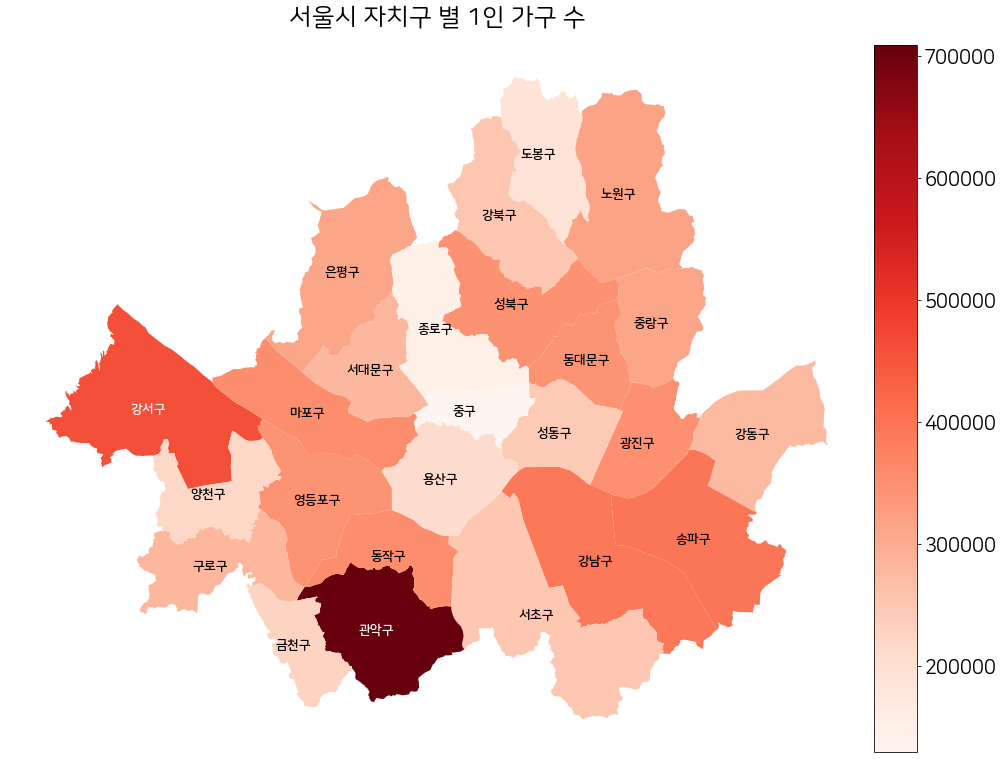

In [16]:
# 행정구역시군구_경계 데이터 
gdf_admin_gu_pg = gpd.read_file('drive/MyDrive/12Team/data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')  
gdf_admin_gu_pg.crs = "epsg:5179"

gdf_admin_gu_pg2 = gdf_admin_gu_pg.to_crs(epsg=3857) 
gdf_admin_gu_pg2["SGG_NM"] = gdf_admin_gu_pg2["SGG_NM"].astype("str")

gp = df_melt.groupby("자치구")['1인가구수'].sum().astype("int")
gdf_admin_gu_pg3 = gdf_admin_gu_pg2.rename(columns={"SGG_NM": "자치구"})
gdf_gu = pd.concat([gdf_admin_gu_pg3.set_index("자치구"), gp], axis=1).reset_index()

fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)

columns = ["자치구", "1인가구수"]
gdf_gu2 = gpd.GeoDataFrame(gdf_gu[columns], geometry=gdf_gu.geometry, crs=from_epsg(3857))
gdf_gu2["center"] = gdf_gu2.geometry.centroid

# 범례
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# 단계구분도
gdf_gu2.plot("1인가구수", ax=ax, legend=True,  cax=cax, cmap='Reds')
ax.set_title("서울시 자치구 별 1인 가구 수", fontsize=25, pad=20)

# 지역명 추가 
for idx in range(len(gdf_gu2)): 
  lat = gdf_gu2.center.iloc[idx].xy[0][0]
  long = gdf_gu2.center.iloc[idx].xy[1][0]
  
  if gdf_gu2["1인가구수"].iloc[idx] >= 400000:
    c = "white"
  else: 
    c = 'black'
  ax.text(lat-1500, long-300, gdf_gu2["자치구"].iloc[idx], fontsize=13, color=c,  fontweight='bold')

ax.set_axis_off()
plt.show()

서울시의 자치구에 따른 1인 가구의 수를 `단계구분도(choropleth)`로 시각화하여 서울시 전체의 1인 가구 수 현황을 파악해보았습니다. 색이 진할 수록 1인가구의 수가 많은 자치구임을 뜻하며, 관악구와 강서구에 1인가구가 가장 많이 분포하고 있음을 알 수 있습니다. 서울시 내에서도 1인 가구수의 분포가 차이가 나는 것을 확인하였습니다. 

<br>
<br>

------

# 2. 1인가구 증가와 사회적 고립 문제

### 서울시 1인가구 추이


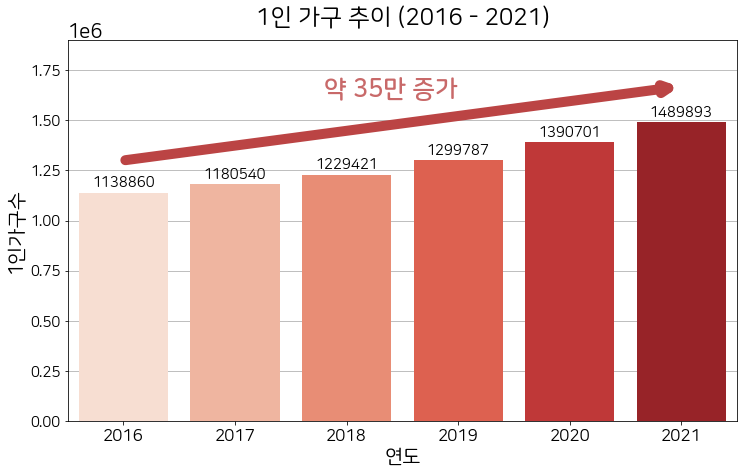

In [17]:
plt.figure(figsize=(12, 7))

plt.title("1인 가구 추이 (2016 - 2021)", pad=15)

bars=sns.barplot(data = df_melt, x="연도", y="1인가구수", estimator=sum, errorbar=None, palette=sns.color_palette("Reds"), zorder=9)

plt.grid(True, axis='y',)


_=plt.annotate('',
              ha = 'center', va = 'bottom',
              xytext = (0, 1300000),
              xy = (5, 1670000),
              arrowprops = {
                            'edgecolor':'#bb4444', 
                            'alpha':1,
                            'arrowstyle':'->',
                            "lw": 10
                })

_=plt.text(1.8, 1620000, '약 35만 증가', fontsize=25, color='#bb4444', fontweight='900', alpha=0.8)


for i, b in enumerate(bars.patches):
    _=plt.text(b.get_x()+b.get_width()*(1/2),b.get_height()+30000, \
            round(b.get_height()),ha='center',fontsize=15, color='k')

_ = plt.yticks(fontsize=15)
_ = plt.xticks(fontsize=17)



_=plt.ylim(0, 1900000)

2016년도 부터 2021년도까지, 서울시의 **각 연도 별 1인가구수 총합**을 막대그래프로 시각화 해봄으로써 1인 가구의 추이를 살펴보았습니다. **2016년도 1138860명** 에서 **2021년도 1489893명**으로, 약 **35만명**이 증가하였음을 알 수 있습니다. `근6년 이상 1인 가구의 수가 지속적으로 증가하는 추이를 보얐으며, 향후에도 계속 증가할 것이라고 전망`되고 있습니다. 

<br> 

서울시 전체 1인가구의 증가 추세에 더하여 연령대 별로 연도 별 1인가구 수를 시각화 해보았을 때도 1인 가구가 증가하는 추이를 보이는지 확인합니다. 

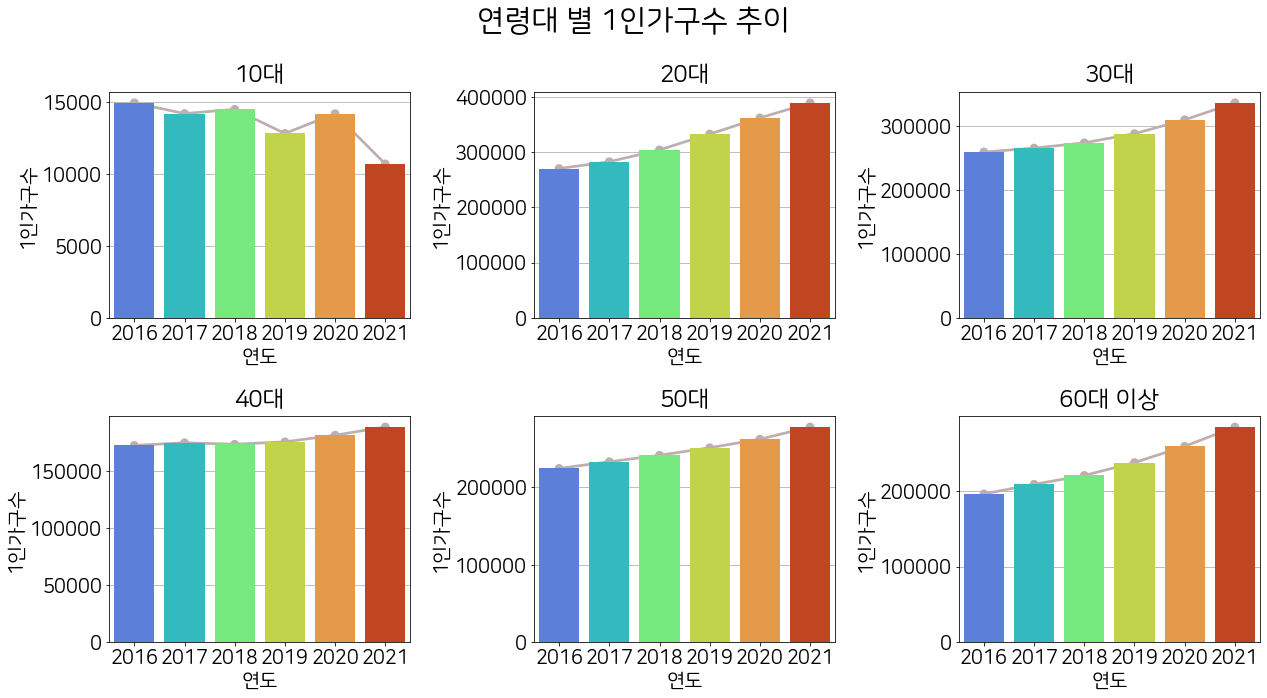

In [32]:
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(2, 3).flatten()

plt.suptitle("연령대 별 1인가구수 추이", fontsize=30)

for idx, age in enumerate(df_melt['연령대'].unique()): 
  if idx == 5: 
    axes[idx].set_title(f"{age}대 이상", pad=10)
  else: 
    axes[idx].set_title(f"{age}대", pad=10)
  sns.barplot(data=df_melt[df_melt["연령대"]==age], x="연도", y='1인가구수', estimator='sum', errorbar=None, palette=sns.color_palette("turbo"), ax=axes[idx], zorder=9)
  sns.pointplot(data=df_melt[df_melt["연령대"]==age], x='연도', y='1인가구수', estimator='sum', ax=axes[idx], errorbar=None, color='#bfaeae')

  axes[idx].grid(True, axis='y', alpha=1)

fig.tight_layout()


10대 부터 60대 이상까지 연령대 별로 나누어 1인가구수 추이를 막대그래프로 시각화 해보았습니다.  10대를 제외한 모든 연령대는 매년 1인가구수가 증가하는 추이를 보이는 것을 확인할 수 있습니다.

<br> 

위의 결과를 토대로 미성년자인 10대는 제외하고, 성인 연령대에 대해서만 분석합니다. 

In [33]:
# 10대 제거 
df_melt = df_melt[~(df_melt["연령대"] == 10)]

# 확인
print(df_melt["연령대"].unique())

[20 30 40 50 60]


<br> 

연령대 별로 1인 가구의 비율이 각각 얼마나 차지하고 있는지 살펴봅니다.

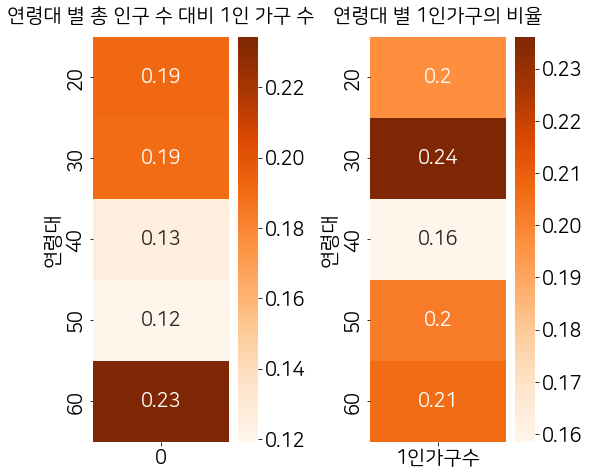

In [20]:
fig = plt.figure(figsize=(8, 7))
ax1, ax2 = fig.subplots(1, 2)

# 연령대 별 총 인구 수 대비 1인 가구 수
sr1 = df_main.groupby("연령대")['1인가구수'].sum() / df_main.groupby("연령대")['총인구'].sum()
sns.heatmap(sr1.to_frame(), cmap='Oranges', annot=True, ax=ax1)
ax1.set_title("연령대 별 총 인구 수 대비 1인 가구 수", pad=15, fontsize=20)

# 연령대 별 1인가구의 비율
sr2 = df_main.groupby("연령대")['1인가구수'].sum() / df_main['1인가구수'].sum()
sns.heatmap(sr2.to_frame(), cmap='Oranges', annot=True, ax=ax2)
ax2.set_title("연령대 별 1인가구의 비율", pad=15, fontsize=20)

fig.tight_layout()
plt.show()

왼쪽의 그래프는 총 인구 수 대비 1인 가구 수, 오른쪽 그래프는 연령대 별 1인가구의 비율을 히트맵으로 시각화 한 그림입니다. 색이 진할수록 높은 비율임을 의미합니다. 총 인구수 대비 1인가구수의 비율은 60대 이상인 집단이 가장 높았고 1인 가구수의 비율은 20~30대, 50대 이상의 집단에서 비등비등하게 나타났습니다. 


### 1인가구 증가와 함께 따라오는 사회적 고립 문제

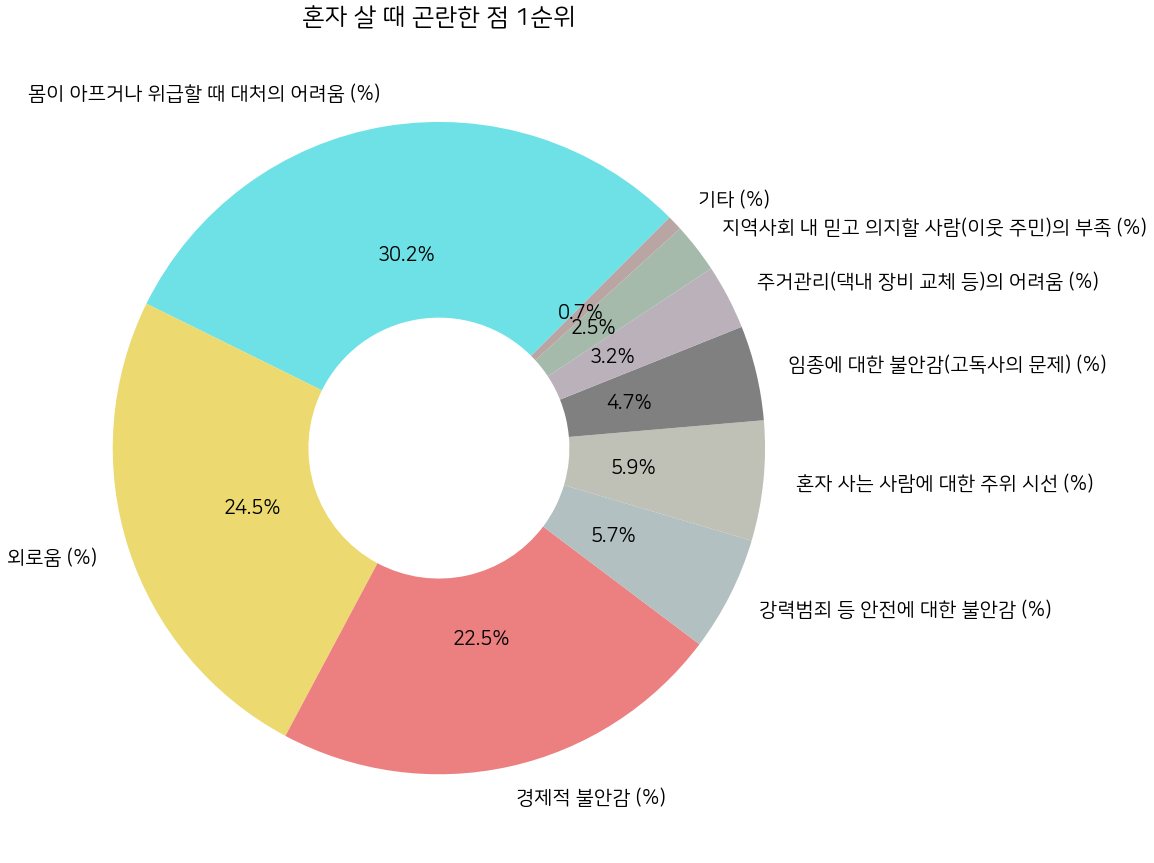

In [60]:
df_lonely_total = df_lonely.set_index("연령대").drop(columns=["사례수 (명)"]).mean(axis=0)
labels = df_lonely_total.index
values = df_lonely_total.values

plt.figure(figsize=(15, 15))
plt.title("혼자 살 때 곤란한 점 1순위", pad=15, fontsize=25)

patches, texts, autotexts = plt.pie(values, 
                                    labels=labels, 
                                    autopct = '%.1f%%',
                                    colors=['#6de1e6', '#ecda70', '#ec7f7f', '#b3c0c1', '#bfc1b6', 'grey', "#bab1bb", "#a5baab", "#baa5a5"],
                                    wedgeprops=dict(width=0.6),
                                    startangle=45

                                    )




plt.show()

위의 도넛차트는 1인가구가 혼자 살면서 곤란한 점 1순위의 설문조사 결과입니다. 가장 많이 비율을 차지하는 것은 **몸이 아프거나 위급할 때 대처의 어려움**, 두번째는 **외로움**, 세번째는 **경제적 불안감**이었습니다. 주거하는 공간에서 함께 생활하는 구성원이 없기에 나타나는 문제점들이 도드라졌으며, 실제로 1인가구는 사회적 고립감을 느끼고있습니다.  

<br>




-------



<br> 

1인가구의 수는 매년 증가하고 있으며 총 인구수 대비 적지 않은 비율을 차지합니다. 그에 따라 사회적 고립 문제가 따라옵니다. 이에 대하여 연령대 별로 어떤 특징을 가지고 있는지 연령대로 나누어 분석합니다.

<br>
<br>

# 3. 연령대별 1인가구의 특징 

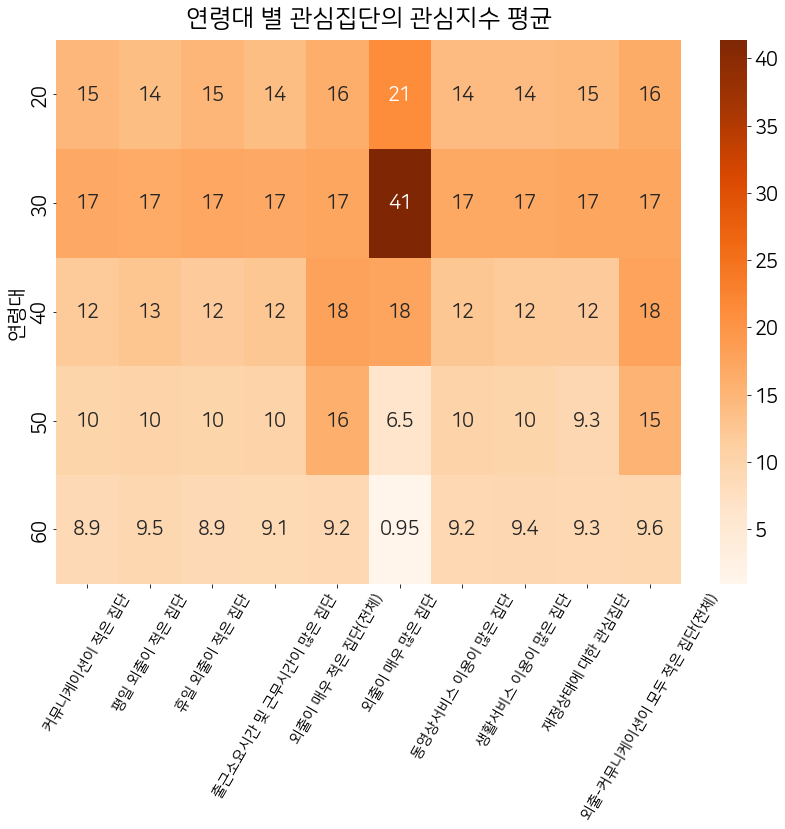

In [21]:
df2 = df_main.drop(columns=["성별", 'out_scaled', 'com_scaled']).iloc[:, 4:].drop(columns=['총인구', '1인가구수']).groupby("연령대").mean()

plt.figure(figsize=(14, 10))
plt.title("연령대 별 관심집단의 관심지수 평균", pad=15, fontsize=25)

sns.heatmap(df2, cmap='Oranges', annot=True)
_ = plt.xticks(fontsize=15, rotation=60)

사용한 데이터셋에서 커뮤니케이션이 적은 집단의 데이터가 의미하는 바는 커뮤니케이션이 적은 집단의 커뮤니케이션 지수를 의미합니다. 따라서 위의 시각화는 연령대 별 각 관심 집단의 관심지수의 평균을 말합니다. 대체적으로 **낮은 연령대일수록 관심지수가 높게 나타나는 것**을 확인할 수 있습니다. 각 컬럼들을 살펴보면, **낮은 연령대가 높은 연령대 보다 사회적인 활동을 더 많이 한다는 것**으로 해석할 수 있습니다. 

<br>

그 중에서도 보다 사회적 활동(외출, 커뮤니케이션)과 관련이 있는 컬럼들만 뽑아 다시 한 번 시각화합니다.

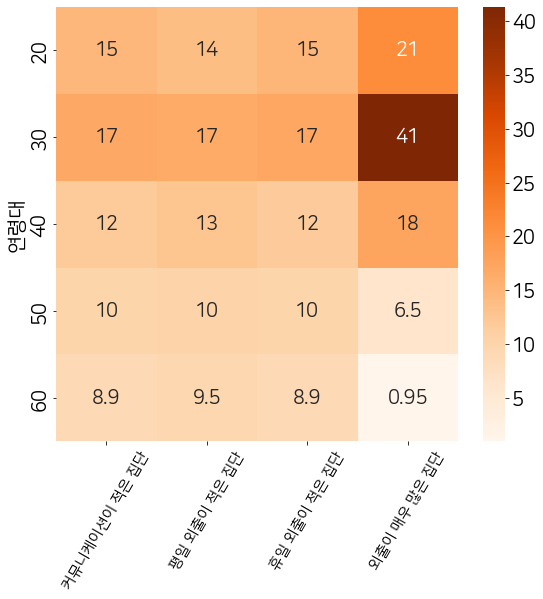

In [22]:
df3 = df_main.groupby("연령대")[["커뮤니케이션이 적은 집단", '평일 외출이 적은 집단', '휴일 외출이 적은 집단', "외출이 매우 많은 집단"]].mean()

plt.figure(figsize=(9, 8))
sns.heatmap(df3, cmap='Oranges', annot=True)
_ = plt.xticks(fontsize=15, rotation=60)

커뮤니케이션이 적은 집단에서 낮은 연령대에서 커뮤니케이션 지수가 더 높게 나왔음을 볼 수 있습니다. 또, 외출이 적은 집단이나, 외출이 매우 많은 집단 모두 낮은 연령대일 수록 각각의 외출 지수가 더 높게 나타났습니다. 특히 **외출이 매우 많은 집단**에서는 **더 큰 편차를 보였습니다.** 

<br>

이는 연령대가 높은, 특히 **50대 이후의 중장년층 세대**의 **사회적 접촉**, **사회적 활동**이 **적으며**, **다른 연령대에 비해 사회적 고립에 더 취약한 연령대**라고 해석할 수 있습니다. 

<br>
<br>

----------

앞서 중장년층 세대의 사회적 활동이 다른 연령대에 비해 적은 것을 확인하였습니다. 따라서 중장년층 세대인 1인 가구에 대해서 더 자세히 살펴봅니다.

# 4. 중장년층의 1인가구

### 중장년층의 낮은 사회적 접촉 

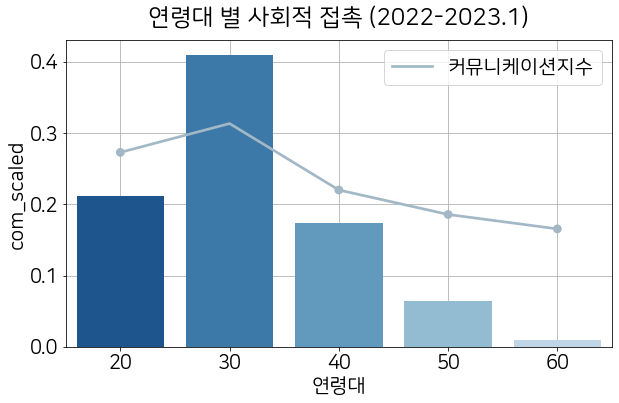

In [23]:
fig = plt.figure(figsize=(9, 6))
ax = fig.subplots(1, 1)

ax.set_title("연령대 별 사회적 접촉 (2022-2023.1)", pad=15)


_=sns.barplot(data=df_main, x='연령대', y='out_scaled', palette=sns.color_palette("Blues_r"), errorbar=None, ax=ax, label="외출지수", zorder=2)
_=sns.pointplot(data=df_main, x='연령대', y='com_scaled', errorbar=None, ax=ax, color='#a2b8c7')

plt.grid(True)
plt.legend(labels=["커뮤니케이션지수"])

fig.tight_layout()

연령대 별 사회적 접촉을 알아보기 위하여 20대 부터 60대 이상의 연령대 별 `외출 지수`와 `커뮤니케이션 지수`를 시각화 해보았습니다. 두 관심지수 모두 40대 이후로 감소하며, 50대 이후의 연령대는 값이 현저히 떨어지는 것을 확인할 수 있습니다. 

### 1인 가구의 혼인상태

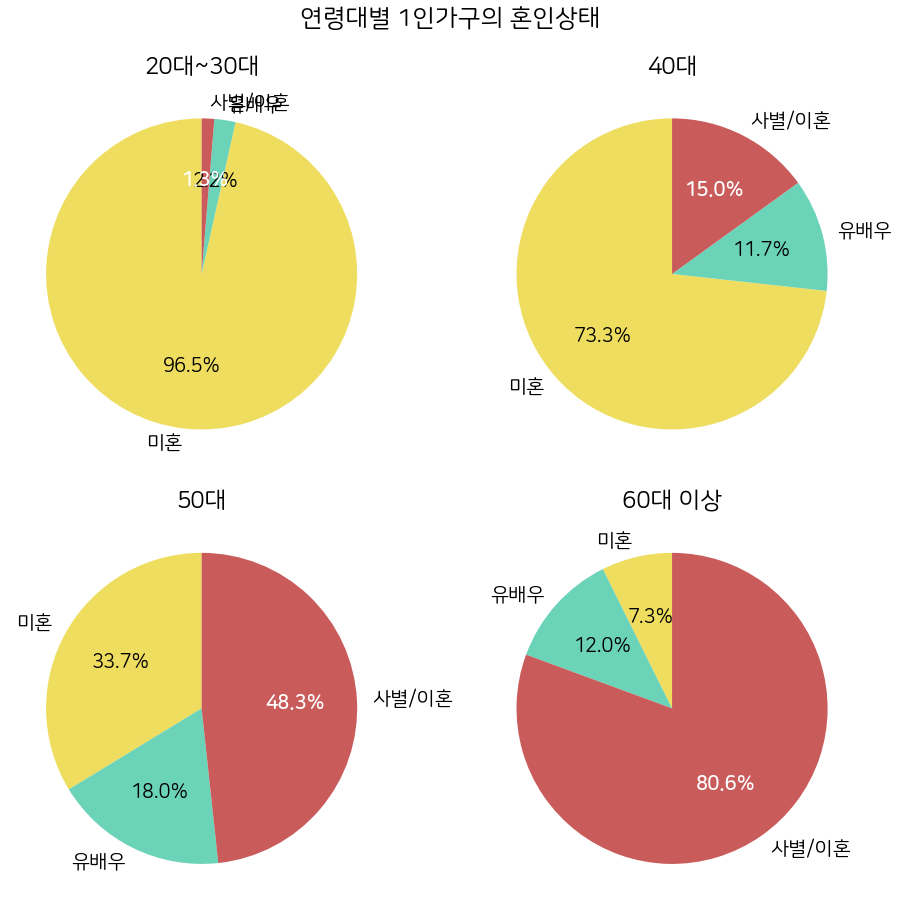

In [49]:
# 20대~30대 40대 50대 60대 
fig = plt.figure(figsize=(13, 13))
axs = fig.subplots(2, 2).flatten() 

df_married = df_married.set_index("연령대")

plt.suptitle("연령대별 1인가구의 혼인상태", fontsize=25)

lst_age = ["20대~30대", "40대", "50대", "60대 이상"]

for idx in range(len(axs)):
  if idx >= 2:
     lst_explode = [0, 0, 0.2]
  else:
    lst_explode = [0, 0, 0]

  patches, texts, autotexts=axs[idx].pie(
      df_married.iloc[idx], 
      labels=df_married.columns, 
      autopct = '%.1f%%', 
      # explode = lst_explode,
      colors=['#eedd5f', '#6bd3b8', '#c95b5b'],
      # wedgeprops=dict(width=0.6),
      startangle=90
      ) 
  _=axs[idx].set_title(f"{lst_age[idx]}")

  for idx, t in enumerate(autotexts):
    if idx == 2: 
      t.set_color("white")
      t.set_weight("900")

fig.tight_layout()

성인이 된 자녀를 모두 출가시키고, 배우자를 먼저 하늘나라로 보낸 뒤 홀로 지내는 이들을 소위 `빈 둥지 노인`이라고 합니다. 연령대 별로 1인가구의 혼인 상태를 시각화 해보았을 때, 연령대가 높아질 수록 미혼의 비율이 줄어들고, 유배우, 사별/이혼의 비율이 높아집니다. 낮은 연령대와 달리 중장년층 이후의 1인가구는 빈 둥지 노인과 같이 자신의 의지로 1인가구를 꾸리지 않는 사람들의 비율도 많습니다.

### 중장년층 1인가구의 외로움

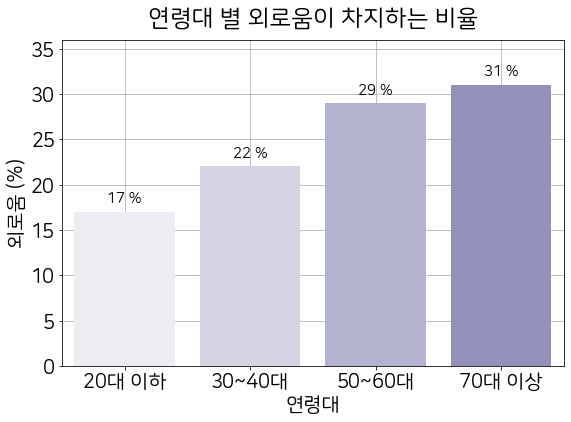

In [28]:
plt.figure(figsize=(9, 6))
plt.title("연령대 별 외로움이 차지하는 비율", pad=15)
bars=sns.barplot(data=df_lonely, x='연령대', y='외로움 (%)', palette=sns.color_palette("Purples"), zorder=2)

plt.grid(True)

for i, b in enumerate(bars.patches):
    _=plt.text(b.get_x()+b.get_width()*(1/2),b.get_height()+1, \
            f"{round(b.get_height())} %",ha='center',fontsize=15, color='k')
    
_=plt.ylim(0, 36)

위에서 보았던 혼자 살 때 곤란한 점 설문조사에서 외로움만 추출하여 연령대 별 비율을 막대 그래프로 시각화 한 결과입니다. 연령대가 높아질 수록 외로움이 1순위로 차지하는 비율이 증가합니다.

------

# 요약

### 1인 가구 증가에 따른 사회적 고립 문제 
- **2016년~2022년 1인 가구수 총합**을 구하여 시간의 경과에 따른 변화량과 데이터지도를 그려봤을때, **연도별 1인 가구수는 지속적으로 증가**하고 있습니다.
- 1인가구가 혼자 살 때 느끼는 곤란함 설문조사 통계 결과 **몸이 아프거나 위급할 때 대처의 어려움, 외로움, 경제적 불안감**이 높은 비율을 차지하였습니다. 

<br>

### 중장년층 세대의 낮은 사회적 접촉 
- 2022년 이후 연령대별로 1인 가구의 **커뮤니케이션지수와 외출지수를 비교해봤을 때, 중년층 이후 수치가 감소**하는 경향을 보입니다.  
- 연령대가 높아질 수록 미혼이 줄어들고, 사별/이혼인 1인가구의 비율이 높습니다.
- 혼자살 때 곤란한 점의 설문조사 결과, 연령대가 높아질수록록 1순위로 외로움을 선택한 비율이 더 높습니다. 


<br>
<br>

#### 분석 결과에 따라, 1인가구 중에서도 사회적 고립 문제에 취약한 연령대인 50대 이후 중장년층 세대를 위한 커뮤니케이션, 외출을 장려할 수 있는 서비스를 개발하고자 합니다. 


<br>
--------------------------------------

  \* `커뮤니케이션이 적은 집단 측정 기준:` 전화/문자 수 발신 대상자 수, 전화/문자 수 발신 건 수,
SNS 사용량 기준


  \* `외출이 매우 많은집단 측정 기준:` 1인가구 대상 근로소득이 3천만원 초과이고, 
휴일의 이동건수와 이동거리가 크고, 
휴일의 추정거주지 체류시간이 적은 사람 기준
(휴일 이동경향이 높은 대상자를 구분하기 위함)
